In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as pl
from tqdm import tqdm
import celeriteflow as cf
import keras
keras.backend.set_floatx("float64")

/mnt/home/dforeman/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def GetTestData(clobber=False):
    """Get test data."""
    data = np.load("data/c6/test_data.npz")
    reg_fluxes = data['reg_fluxes']
    reg_pixels = data['reg_pixels']
    reg_npix = data['reg_npix']
    time = data['time']
    flux = data['flux']
    flux_err = data['flux_err']
    return time, reg_fluxes, reg_pixels, reg_npix, flux, flux_err

In [3]:
def value(self, tau):
    ar, cr, ac, bc, cc, dc = self.get_coefficients()
    tau = tf.abs(tau)
    tau = tf.reshape(tau, tf.concat([tau.shape, [1]], axis=0))
    K = tf.reduce_sum(ar * tf.exp(-cr*tau), axis=-1)
    factor = tf.exp(-cc*tau)
    K += tf.reduce_sum(ac * factor * tf.cos(dc*tau), axis=-1)
    K += tf.reduce_sum(bc * factor * tf.sin(dc*tau), axis=-1)
    return K

In [19]:
# Grab the data
time, reg_fluxes, reg_pixels, reg_npix, flux, flux_err = GetTestData()
ntime = flux.shape[0]
nreg = reg_fluxes.shape[0]

# Set up tensorflow
import tensorflow as tf
dtype = tf.float64

# Tweakable stuff
logjitter0 = np.log(0.01)  # Initial log jitter
l0 = 1e-2  # Initial L2 regularization variance
learning_rate = 1e-2  # Initial Adam learning rate
P0 = 10.0  # Period guess
H = 10  # Dimension of the hidden layer

# Constants
t = tf.placeholder(dtype, shape=(None,))
y = tf.placeholder(dtype, shape=(None,))
y_err = tf.placeholder(dtype, shape=(None,))

# t = tf.constant(time, dtype=dtype)
# y = tf.constant(flux - 1.0, dtype=dtype)
# y_err = tf.constant(flux_err, dtype=dtype)

# Compute weakly regularized max like solution as a guess
X = reg_fluxes.T - 1.0
L = np.diag(np.ones(nreg) * l0 ** 2)
LXT = np.dot(L, X.T)
S = np.dot(X, np.dot(L, X.T))
S += np.diag(flux_err ** 2 + np.exp(2 * logjitter0))
Sinvy = np.linalg.solve(S, (flux - 1.0)[:, None])
wguess = np.dot(LXT, Sinvy)

# Keras NN model
nn = keras.Sequential()
nn.add(keras.layers.Dense(H, activation="softmax", input_dim=nreg))
nn.add(keras.layers.Dense(1))
model = tf.squeeze(nn.output)

# Celerite GP
logjitter = tf.Variable(logjitter0, dtype=dtype)
diag = y_err ** 2 + tf.exp(2*logjitter)
resid = y - model
log_S0 = tf.Variable(np.log(np.var(flux)), dtype=dtype)
log_w0 = tf.Variable(np.log(2 * np.pi / P0), dtype=dtype)
log_Q = tf.Variable(0.0, dtype=dtype)
kernel = cf.terms.SHOTerm(log_S0=log_S0,
                          log_w0=log_w0,
                          log_Q=log_Q)
gp = cf.GaussianProcess(kernel, t, resid, diag)
loglike = gp.log_likelihood

pred = y - tf.squeeze(gp.alpha) * diag
gp_pred = pred - model

# Losses
l = tf.constant(l0, dtype=dtype)
loss = -2 * loglike
for w in nn.trainable_weights:
    loss += (1 / l) * tf.reduce_sum(tf.abs(w))
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Init session
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

# Assign initial guess for the weights
w1_0 = 1e-6 * np.random.randn(nreg, H)
w1_0[:, 0] = wguess[:, 0]
w2_0 = 1e-6 * np.random.randn(H, 1)
w2_0[0, 0] = 1
session.run(tf.assign(nn.layers[0].kernel, w1_0))
session.run(tf.assign(nn.layers[0].bias, 1e-6 * np.random.randn(H)))
session.run(tf.assign(nn.layers[1].kernel, w2_0))
session.run(tf.assign(nn.layers[1].bias, [-0.5]))

array([-0.5])

In [20]:
mask = np.ones(ntime, dtype=bool)
feed_dict = {
    nn.input: reg_fluxes[:, mask].T - 1.0,
    t: time[mask],
    y: flux[mask] - 1.0,
    y_err: flux_err[mask],
}

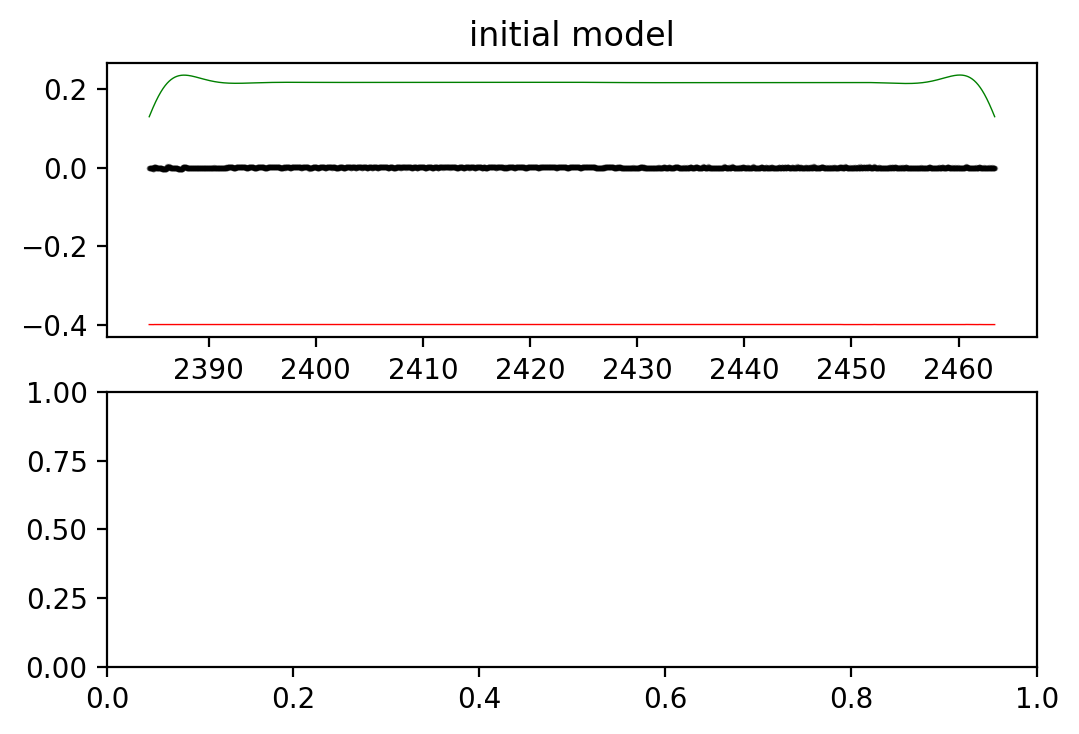

In [21]:
# Plot initial model
model0 = model.eval(feed_dict=feed_dict)
pred0 = pred.eval(feed_dict=feed_dict)

fig, ax = pl.subplots(2)
ax[0].set_title("initial model")
ax[0].plot(time, flux - 1, 'k.', ms=2, alpha=0.3)
ax[0].plot(time, model0, 'r-', lw=0.5)
ax[0].plot(time, pred0 - model0, 'g-', lw=0.5)

In [22]:
# Iterate!
niter = 500  # Number of iterations
losses = np.zeros(niter)
best_loss = np.inf
for i in tqdm(range(niter)):
    session.run(opt, feed_dict=feed_dict)
    losses[i] = loss.eval(feed_dict=feed_dict)
    if losses[i] < best_loss:
        best_loss = losses[i]
        best_weights = session.run(nn.trainable_weights)
        best_logjitter = logjitter.eval()
        best_log_S0 = log_S0.eval()
        best_log_w0 = log_w0.eval()
        best_log_Q = log_Q.eval()
session.run([
    tf.assign(a, b) for a, b in zip(nn.trainable_weights, best_weights)])
session.run(tf.assign(logjitter, best_logjitter))
session.run(tf.assign(log_S0, best_log_S0))
session.run(tf.assign(log_w0, best_log_w0))
session.run(tf.assign(log_Q, best_log_Q))

# Log
print("GP stuff:", best_logjitter, best_log_S0, best_log_w0, best_log_Q)

100%|██████████| 500/500 [00:58<00:00,  8.61it/s]


GP stuff: -4.517783101808926 -13.461330218193083 -0.6201072288071788 -0.1621615819390012


In [23]:
delta = (y - pred).eval(feed_dict=feed_dict)
sd = np.sqrt(np.median(delta**2))
mask[mask] = np.abs(delta) < 7*sd
feed_dict = {
    nn.input: reg_fluxes[:, mask].T - 1.0,
    t: time[mask],
    y: flux[mask] - 1.0,
    y_err: flux_err[mask],
}

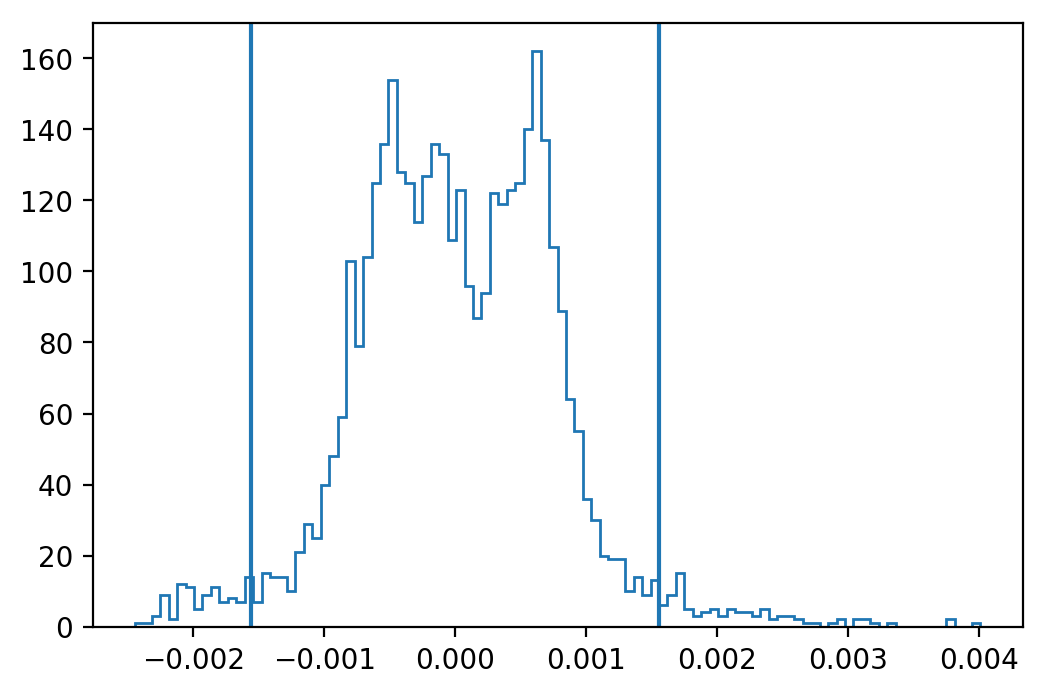

In [24]:
pl.hist(delta, 100, histtype="step")
pl.axvline(3*sd)
pl.axvline(-3*sd);

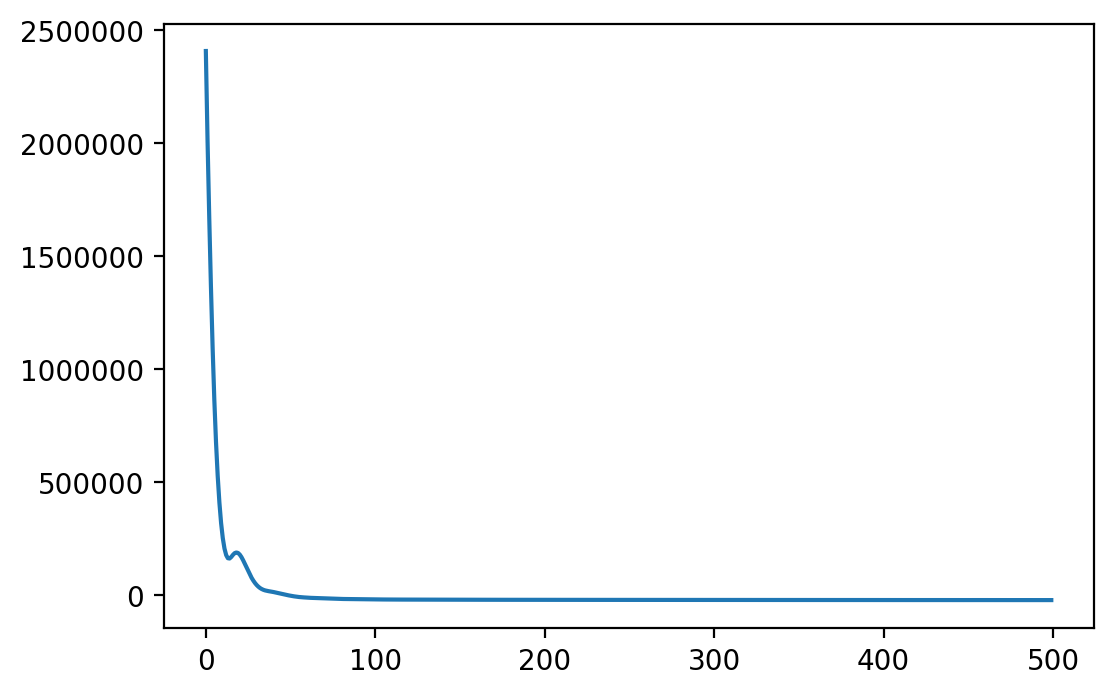

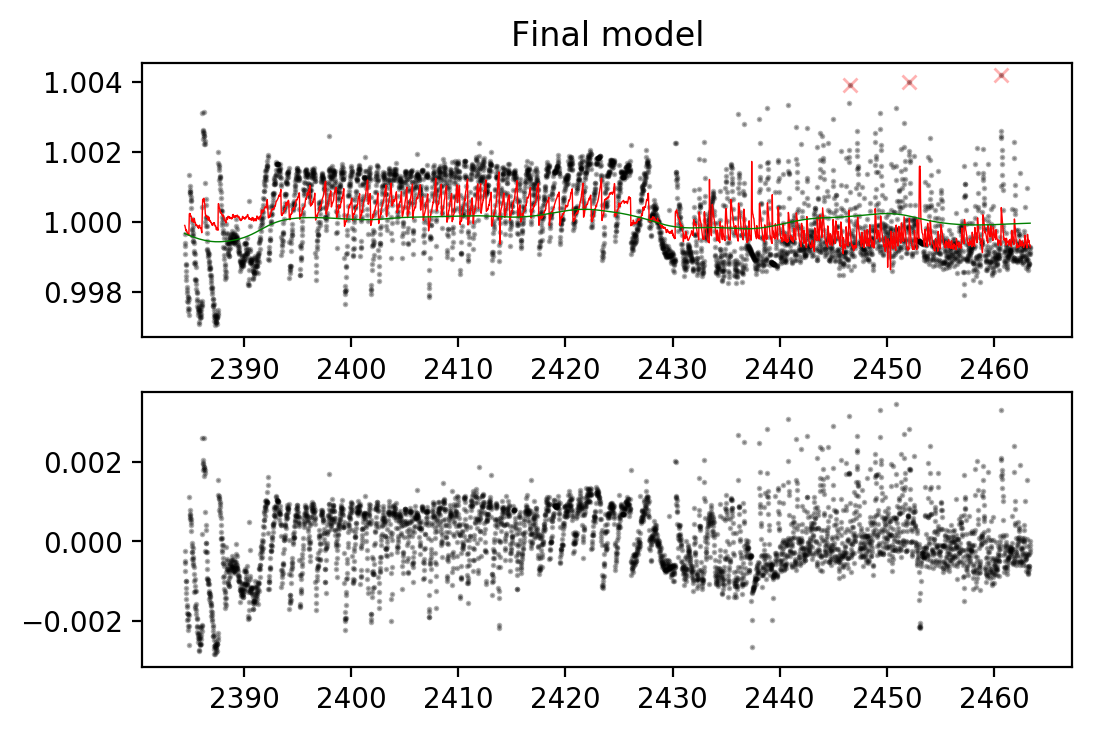

In [25]:
# Plot learning rate
fig, ax = pl.subplots(1)
ax.plot(range(niter), losses)

# Plot final model
fig, ax = pl.subplots(2)
ax[0].set_title("Final model")
ax[0].plot(time, flux, 'k.', ms=2, alpha=0.3)
ax[0].plot(time[~mask], flux[~mask], 'rx', ms=5, alpha=0.3)
ax[0].plot(time[mask], 1 + model.eval(feed_dict=feed_dict), 'r-', lw=0.5)
ax[0].plot(time[mask], 1 + gp_pred.eval(feed_dict=feed_dict), 'g-', lw=0.5)

ax[1].plot(time[mask], (y - model).eval(feed_dict=feed_dict), 'k.', ms=2, alpha=0.3)
# ax[1].plot(time[~mask], (y - model).eval(feed_dict=feed_dict)[~mask], 'rx', ms=2, alpha=0.3)

In [19]:
def to_dense(self, x, diag):
    K = self.value(x[:, None] - x[None, :])
    K += tf.diag(diag)
    return K

def psd(self, omega):
    ar, cr, ac, bc, cc, dc = self.get_coefficients()
    omega = tf.reshape(omega, tf.concat([omega.shape, [1]], axis=0))
    w2 = omega**2
    w02 = cc**2 + dc**2
    power = tf.reduce_sum(ar * cr / (cr**2 + w2), axis=-1)
    power += tf.reduce_sum(((ac*cc+bc*dc)*w02+(ac*cc-bc*dc)*w2) /
                           (w2*w2 + 2.0*(cc**2-dc**2)*w2+w02*w02), axis=-1)
    return np.sqrt(2.0 / np.pi) * power

def value(self, tau):
    ar, cr, ac, bc, cc, dc = self.get_coefficients()
    tau = tf.abs(tau)
    tau = tf.reshape(tau, tf.concat([tau.shape, [1]], axis=0))
    K = tf.reduce_sum(ar * tf.exp(-cr*tau), axis=-1)
    factor = tf.exp(-cc*tau)
    K += tf.reduce_sum(ac * factor * tf.cos(dc*tau), axis=-1)
    K += tf.reduce_sum(bc * factor * tf.sin(dc*tau), axis=-1)
    return K


array([[ 3.61439580e-05,  3.60569903e-05,  3.57978068e-05, ...,
        -1.17529577e-14, -1.13914895e-14, -1.09793673e-14],
       [ 3.60569903e-05,  3.61439580e-05,  3.60569895e-05, ...,
        -1.20614475e-14, -1.17529658e-14, -1.13914988e-14],
       [ 3.57978068e-05,  3.60569895e-05,  3.61439580e-05, ...,
        -1.23148502e-14, -1.20614556e-14, -1.17529754e-14],
       ...,
       [-1.17529577e-14, -1.20614475e-14, -1.23148502e-14, ...,
         3.61439580e-05,  3.60569945e-05,  3.57978250e-05],
       [-1.13914895e-14, -1.17529658e-14, -1.20614556e-14, ...,
         3.60569945e-05,  3.61439580e-05,  3.60569945e-05],
       [-1.09793673e-14, -1.13914988e-14, -1.17529754e-14, ...,
         3.57978250e-05,  3.60569945e-05,  3.61439580e-05]])